# Top2Vec to conduct Topic Modelling on Coursera Data

We will first cluster the topics within each program: Then, we will vectorise the module summaries, do dimensionality reduction before using HDBSCAN to generate the topics. Then, it will extract the top 5-10 keywords per topic (exact number to be determined after fine-tuning) using c-TF-IDF.

The difference between using Top2Vec compared to using BERT is that keyword extraction is done by taking the keyword vectors that are closest to the topic centroid.

# 1.0 Importing Libraries and Coursera Dataset

In [18]:
import pandas as pd
import numpy as np
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from gensim.models import CoherenceModel
from top2vec import Top2Vec
import time
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import gensim.corpora as corpora
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [19]:
df_program = pd.read_csv('data/prog_scraped.csv')
df_course = pd.read_csv('data/course_scraped.csv')
df_module = pd.read_csv('data/module_scraped.csv') 

In [20]:
df_program.rename(columns={'Unnamed: 0':'id'}, inplace=True)

df_program.head()    

,id,prog_title,org,cert_type,enrolled,num_courses,rating,num_reviews,difficulty,prog_lo_description,prog_lo_skills,prog_description,course_title_description_skills,url
0,0,ISC2 Systems Security Certified Practitioner (...,ISC2,Specialization,"22,401",7,4.8,973.0,Beginner,"Implement, monitor and administer an organizat...",Security Engineering;Network Security;Leadersh...,Pursue better IT security job opportunities an...,Security Concepts and Practices|Course 1 - Sec...,https://www.coursera.org/specializations/sscp-...
1,1,.NET FullStack Developer Specialization,Board Infinity,Specialization,"11,753",3,4.1,259.0,Intermediate,Master .NET full stack web dev: from .NET core...,Model–View–Controller (MVC);HTML;React (Web Fr...,Develop the proficiency required to design and...,.Net Full Stack Foundation|Understand .NET fra...,https://www.coursera.org/specializations/dot-n...
2,2,AI For Business Specialization,University of Pennsylvania,Specialization,"39,842",4,4.7,1.0,Beginner,NaN,Machine Learning;Machine Learning Algorithms;A...,This specialization will provide learners with...,AI Fundamentals for Non-Data Scientists|In thi...,https://www.coursera.org/specializations/ai-fo...
3,3,AI Foundations for Everyone Specialization,IBM,Specialization,"44,046",4,4.7,3.0,Beginner,NaN,Cloud Computing;Human Computer Interaction;Hum...,Artificial Intelligence (AI) is no longer scie...,Introduction to Artificial Intelligence (AI)|D...,https://www.coursera.org/specializations/ai-fo...
4,4,AI Product Management Specialization,Duke University,Specialization,"40,831",3,4.7,636.0,Beginner,Identify when and how machine learning can app...,Machine Learning;Machine Learning Algorithms;A...,Organizations in every industry are accelerati...,Machine Learning Foundations for Product Manag...,https://www.coursera.org/specializations/ai-pr...


# 2.0 Exploratory Data Analysis and Text Processing for Top2Vec

In [21]:
print(df_program.shape)
print(df_program.columns)

(474, 14)
Index(['id', 'prog_title', 'org', 'cert_type', 'enrolled', 'num_courses',
       'rating', 'num_reviews', 'difficulty', 'prog_lo_description',
       'prog_lo_skills', 'prog_description', 'course_title_description_skills',
       'url'],
      dtype='object')


In [22]:
df_program.info()      
df_program.isnull().sum()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               474 non-null    int64  
 1   prog_title                       474 non-null    object 
 2   org                              464 non-null    object 
 3   cert_type                        474 non-null    object 
 4   enrolled                         460 non-null    object 
 5   num_courses                      474 non-null    int64  
 6   rating                           467 non-null    float64
 7   num_reviews                      467 non-null    float64
 8   difficulty                       474 non-null    object 
 9   prog_lo_description              328 non-null    object 
 10  prog_lo_skills                   468 non-null    object 
 11  prog_description                 473 non-null    object 
 12  course_title_descripti

id                                   0
prog_title                           0
org                                 10
cert_type                            0
enrolled                            14
num_courses                          0
rating                               7
num_reviews                          7
difficulty                           0
prog_lo_description                146
prog_lo_skills                       6
prog_description                     1
course_title_description_skills      0
url                                  0
dtype: int64

In [23]:
df_program['prog_description'] = df_program['prog_description'].fillna('')
df_program['prog_lo_description'] = df_program['prog_lo_description'].fillna('')

#Check for any more missing values in prog_description and prog_lo_description
df_program.isnull().sum()

print("nan removed")

nan removed


In [24]:
# Combine the program description and the learning outcomes description for each program
def combine_text(row):
    '''
    combines the lo_description (meant act as the summary) and the program description for ease in topic modelling
    '''
    lo_descriptions = row["prog_lo_description"].split(";") 
    lo_text = " ".join(lo_descriptions)
    combined = row["prog_description"] + " " + lo_text
    return combined

df_program["combined_text"] = df_program.apply(combine_text, axis=1)
print("Combined data for row 0:\n", df_program["combined_text"][0])

Combined data for row 0:
 Pursue better IT security job opportunities and prove knowledge with confidence. The SSCP Professional Training Certificate shows employers you have the IT security foundation to defend against cyber attacks – and puts you on a clear path to earning SSCP certification.;Upon completing the SSCP Professional Certificate, you will:;Complete seven courses of preparing you to sit for the Systems Security Certified Practitioner (SSCP) certification exam Opens in a new tabas outlined below.;Course 1 - Security Concepts and Practices;Course 2 - Access Controls;Course 3 - Risk Identification, Monitoring, and Analysis;Course 4 - Incident Response and Recovery;Course 5 - Cryptography;Course 6 - Network and Communications Security;Course 7 - Systems and Application Security;Receive a certificate of program completion.;Understand how to implement, monitor and administer an organization’s IT infrastructure in accordance with security policies and procedures that ensure data

In [25]:
#Remove stopwords and punctuation
coursera_stopwords = [
    "course", "program", "learn", "learning", "outcome", "outcomes",
    "description", "skill", "skills", "module", "modules", "specialization",
    "specialisation", "certificate", "certificates", "certificate,", "certificates,",
    "professional", "career", "opportunity", "opportunities", "project", "projects", "work", "experience", "experiences"]

STOP_WORDS = STOP_WORDS.union(coursera_stopwords)

def preprocess_text(text: str):
    '''
    1. Lowercase conversion
    2. Removing nonalphanumeric characters
    3. Removing stopwords, punctuation
    '''
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    return " ".join([
        w for w in words
        if len(w) > 2 and w not in STOP_WORDS
    ])
    
df_program["cleaned_text"] = df_program["combined_text"].apply(preprocess_text)
print("Cleaned Text:", df_program["cleaned_text"][0])

Cleaned Text: pursue better security job prove knowledge confidence sscp training shows employers security foundation defend cyber attacks puts clear path earning sscp certificationupon completing sscp willcomplete seven courses preparing sit systems security certified practitioner sscp certification exam opens new tabas outlined belowcourse security concepts practicescourse access controlscourse risk identification monitoring analysiscourse incident response recoverycourse cryptographycourse network communications securitycourse systems application securityreceive completionunderstand implement monitor administer organizations infrastructure accordance security policies procedures ensure data confidentiality integrity availabilityapplied projecteach includes final assessment knowledge checks require students practice knowledge gained successful completion assessments require basic understanding topics covered ability relate topics real world implement monitor administer organizations 

# 3.0 Training Pipeline for 3 Models

In [26]:
def train_models(df, cleaned_text_column='cleaned_text', id_column='id'):
    """
    Train and return Top2Vec models with different embedding approaches.
    Only returns models that successfully generate at least one topic.
    """
    docs = df[cleaned_text_column].tolist()
    doc_ids = df[id_column].tolist()
    models = {}

    def train_and_validate(name, embedding_model):
        print(f"\nTraining {name} model...")
        start_time = time.time()
        try:
            model = Top2Vec(
                documents=docs,
                embedding_model=embedding_model,
                keep_documents=True,
                document_ids=doc_ids,
                speed='learn',
                workers=4
            )
            topic_sizes, topic_nums = model.get_topic_sizes()
            if len(topic_nums) == 0:
                print(f"{name} model trained but found **no topics** — skipping.")
                return None
            print(f"{name} model trained in {(time.time() - start_time)/60:.2f} minutes")
            return model
        except Exception as e:
            print(f"Failed to train {name} model: {e}")
            return None

    # Train Doc2Vec
    models['doc2vec'] = train_and_validate("Doc2Vec", 'doc2vec')

    # Train Sentence-BERT
    models['sbert'] = train_and_validate("SBERT", 'all-MiniLM-L6-v2')

    return models

# Function to save models to specific folder
def save_models(models, folder='saved models'):
    """
    Save Top2Vec models to disk.
    """
    for name, model in models.items():
        if model is not None:
            model.save(f'{folder}/{name}.pkl')
            print(f"{name} model saved to disk.")
        
# Apply the function to train the models
models = train_models(df_program)
save_models(models)


2025-03-23 14:44:47,921 - top2vec - INFO - Pre-processing documents for training



Training Doc2Vec model...


2025-03-23 14:44:48,119 - top2vec - INFO - Creating joint document/word embedding
2025-03-23 14:44:51,735 - top2vec - INFO - Creating lower dimension embedding of documents
2025-03-23 14:44:52,360 - top2vec - INFO - Finding dense areas of documents
2025-03-23 14:44:52,379 - top2vec - INFO - Finding topics
2025-03-23 14:44:52,392 - top2vec - INFO - Pre-processing documents for training


Doc2Vec model trained in 0.07 minutes

Training SBERT model...


2025-03-23 14:44:52,660 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
2025-03-23 14:44:55,803 - top2vec - INFO - Creating joint document/word embedding
2025-03-23 14:45:17,270 - top2vec - INFO - Creating lower dimension embedding of documents
2025-03-23 14:45:18,517 - top2vec - INFO - Finding dense areas of documents
2025-03-23 14:45:18,552 - top2vec - INFO - Finding topics


SBERT model trained in 0.44 minutes
doc2vec model saved to disk.
sbert model saved to disk.


# 4.0 Evaluation of the 3 models using Gensim Coherence Scoring

## 4.1 Text Pre-Processing for Gensim

In [27]:
# Extract topics for coherence
def extract_topics_for_coherence(model):
    """
    Extract topics from a Top2Vec model using get_topics(),
    adapted for versions where get_topic_words/get_topic are not available.
    """
    try:
        topic_words, word_scores, topic_nums = model.get_topics()
        topic_sizes, _ = model.get_topic_sizes()

        topics = [list(words[:20]) for words in topic_words]

        return topics, topic_nums, topic_sizes

    except Exception as e:
        raise RuntimeError(f"Error extracting topics: {e}")

## 4.2 Define functions for evaluation

In [28]:
def calculate_coherence(model, texts_tokens):
    dictionary = corpora.Dictionary(texts_tokens)
    corpus = [dictionary.doc2bow(text) for text in texts_tokens]

    topics, topic_nums, topic_sizes = extract_topics_for_coherence(model)

    coherence_model = CoherenceModel(
        topics=topics,
        texts=texts_tokens,
        dictionary=dictionary,
        coherence='c_v'
    )

    overall_coherence = coherence_model.get_coherence()
    topic_coherences = coherence_model.get_coherence_per_topic()

    topic_data = []
    for i, (topic_num, size, coherence) in enumerate(zip(topic_nums, topic_sizes, topic_coherences)):
        top_words = ", ".join(topics[i][:10])
        topic_data.append({
            'Topic': i,
            'Size': size,
            'Coherence': coherence,
            'Top Words': top_words
        })

    topic_df = pd.DataFrame(topic_data)

    return overall_coherence, topic_df


## 4.3 Evaluation Pipeline 

In [29]:
# Function to evaluate models
def evaluate_models(models, texts_tokens):
    """
    Evaluate all models using coherence scores
    """
    results = {}
    topic_dfs = {}
    
    for name, model in models.items():
        print(f"\nEvaluating {name} model...")
        overall_coherence, topic_df = calculate_coherence(model, texts_tokens)
        results[name] = overall_coherence
        topic_dfs[name] = topic_df
        
        print(f"Model: {name}")
        print(f"Number of topics: {len(topic_df)}")
        print(f"Overall coherence score (C_v): {overall_coherence:.4f}")
        print(f"Average topic coherence: {topic_df['Coherence'].mean():.4f}")
        print(f"Min topic coherence: {topic_df['Coherence'].min():.4f}")
        print(f"Max topic coherence: {topic_df['Coherence'].max():.4f}")
    
    return results, topic_dfs

In [30]:
# Compare the 3 models
# Function to visualize coherence scores
def display_coherence_table(results, topic_dfs):
    df = pd.DataFrame([
        {
            'Model': model,
            'Num Topics': len(topic_dfs[model]),
            'Overall Coherence (C_v)': results[model],
            'Avg Topic Coherence': topic_dfs[model]['Coherence'].mean(),
            'Max Topic Coherence': topic_dfs[model]['Coherence'].max(),
            'Min Topic Coherence': topic_dfs[model]['Coherence'].min()
        }
        for model in results
    ])
    
    return df.style.background_gradient(cmap='Blues').format(precision=4)

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

def plot_model_topic_overlap(models, top_n=10):
    model_names = list(models.keys())
    n = len(model_names)
    overlap_matrix = np.zeros((n, n))

    # Extract topics for each model
    model_topics = {
        name: [set(words[:top_n]) for words in model.get_topics()[0]]
        for name, model in models.items()
    }

    for i, name_i in enumerate(model_names):
        for j, name_j in enumerate(model_names):
            if i == j:
                overlap_matrix[i, j] = 1.0
            else:
                overlaps = [
                    max(jaccard_similarity(t1, t2) for t2 in model_topics[name_j])
                    for t1 in model_topics[name_i]
                ]
                overlap_matrix[i, j] = np.mean(overlaps)

    plt.figure(figsize=(8, 6))
    sns.heatmap(overlap_matrix, annot=True, xticklabels=model_names, yticklabels=model_names, cmap='YlGnBu')
    plt.title("Average Jaccard Similarity of Topics Between Models")
    plt.show()
    
def compare_document_clustering(models, df, text_column='cleaned_text'):
    """
    Compare how documents are clustered by different models
    """
    sample_size = min(5, len(df))
    sample_indices = np.random.choice(range(len(df)), sample_size, replace=False)
    
    results = []

    for idx in sample_indices:
        doc_text = df.iloc[idx][text_column]
        doc_id = df.iloc[idx]['id']
        doc_result = {
            'Document': doc_text[:100] + '...' if len(doc_text) > 100 else doc_text
        }

        for name, model in models.items():
            try:
                # Convert doc_id lookup for NumPy array
                doc_idx = np.where(model.document_ids == doc_id)[0][0]

                # Get document-topic mapping
                doc_topics = model.get_documents_topics([doc_idx])[0]
                topic_num = doc_topics[0] if isinstance(doc_topics, (list, np.ndarray)) else doc_topics

                # Get topic words using your get_topics() structure
                topic_words, _, topic_nums = model.get_topics()
                topic_index = np.where(topic_nums == topic_num)[0][0]
                top_words = topic_words[topic_index][:5]

                doc_result[f'{name}_topic'] = topic_num
                doc_result[f'{name}_top_words'] = ', '.join(top_words)

            except Exception as e:
                doc_result[f'{name}_topic'] = 'Error'
                doc_result[f'{name}_top_words'] = f'Failed: {e}'

        results.append(doc_result)

    comparison_df = pd.DataFrame(results)
    return comparison_df



Evaluating doc2vec model...
Model: doc2vec
Number of topics: 2
Overall coherence score (C_v): 0.2615
Average topic coherence: 0.2615
Min topic coherence: 0.2385
Max topic coherence: 0.2845

Evaluating sbert model...
Model: sbert
Number of topics: 2
Overall coherence score (C_v): 0.2205
Average topic coherence: 0.2205
Min topic coherence: 0.1994
Max topic coherence: 0.2416


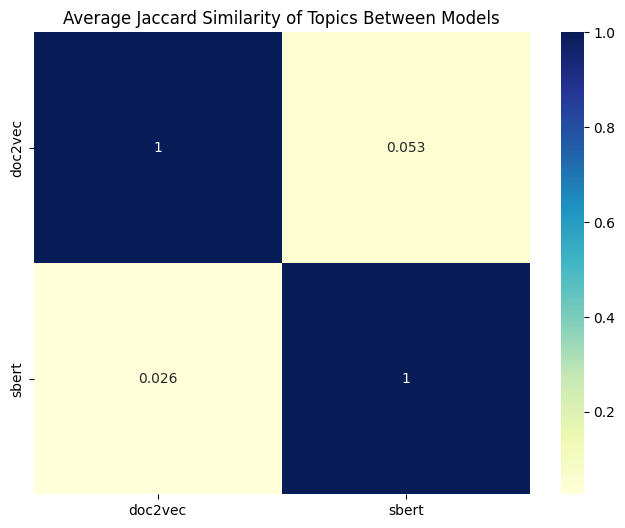

,Document,doc2vec_topic,doc2vec_top_words,sbert_topic,sbert_top_words
0,knowledge tools need record produce sounding m...,0,"series, fundamentals, problems, end, assessments",0,"courses, programming, developing, develop, app..."
1,intended novice business professionals seeking...,0,"series, fundamentals, problems, end, assessments",0,"courses, programming, developing, develop, app..."
2,graphic design myriad forms screen print image...,0,"series, fundamentals, problems, end, assessments",0,"courses, programming, developing, develop, app..."
3,courses taken academic credit ecea boulders ma...,0,"series, fundamentals, problems, end, assessments",0,"courses, programming, developing, develop, app..."
4,takes critical look digital advertising tactic...,0,"series, fundamentals, problems, end, assessments",0,"courses, programming, developing, develop, app..."


In [31]:
# Function to run the evaluation pipeline
def run_evaluation_pipeline(models, df, text_column='cleaned_text'):
    """
    Run the entire evaluation pipeline
    """
    # Tokenize text
    texts_tokens = [text.split() for text in df[text_column]]
    
    # Evaluate models
    results, topic_dfs = evaluate_models(models, texts_tokens)
    
    # Visualize coherence scores
    display_coherence_table(results, topic_dfs)
    plot_model_topic_overlap(models)
    
    # Compare document clustering
    comparison_df = compare_document_clustering(models, df, text_column)
    
    return results, topic_dfs, comparison_df

#Apply the functions
results, topic_dfs, comparison_df = run_evaluation_pipeline(models, df_program)
comparison_df.head()